In [2]:
import tpx3awkward as tpx
from tiled.client import from_uri
import pandas as pd
import numpy as np
from fast_histogram import histogram1d, histogram2d
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.setrecursionlimit(5000)

db = from_uri('https://tiled.nsls2.bnl.gov', 'dask')['chx']['raw']

In [3]:
## Example 1 - SPDC Data - Auto

file_list_1 = db[143100]['primary']['data']['tpx3_files_raw_filepaths'][0].compute()
file_list_1 = [file.replace('file:', '') for file in file_list_1]

In [4]:
## Example 2 - XPCS Data - Manual Scan (e.g. not with bsui)

base_path = "/nsls2/data/chx/proposals/2025-1/pass-318004/tpx3data_manual/"
file_list_2 = [f"{base_path}manual{n}.tpx3" for n in range(3000000, 3000005)]

In [5]:
example_file = file_list_1[0]

In [6]:
df = tpx.tpx_to_raw_df(example_file)
df

,x,y,ToT,t,chip
0,55,126,525,11301258,3
1,56,126,125,11301268,3
2,461,121,275,11303173,0
3,258,118,475,11303316,0
4,493,242,400,11303785,0
...,...,...,...,...,...
1040945,279,57,400,641279783,0
1040946,278,57,175,641279789,0
1040947,368,176,325,641280573,0
1040948,369,176,225,641280578,0


In [7]:
cluster_labels, events = tpx.cluster_df_optimized(df, tpx.DEFAULT_CLUSTER_TW, tpx.DEFAULT_CLUSTER_RADIUS)
df['cluster_id'] = cluster_labels
df

,x,y,ToT,t,chip,cluster_id
0,55,126,525,11301258,3,0
1,56,126,125,11301268,3,0
2,461,121,275,11303173,0,1
3,258,118,475,11303316,0,2
4,493,242,400,11303785,0,3
...,...,...,...,...,...,...
1040945,279,57,400,641279783,0,706378
1040946,278,57,175,641279789,0,706378
1040947,368,176,325,641280573,0,706379
1040948,369,176,225,641280578,0,706379


In [8]:
cluster_array = tpx.group_indices(cluster_labels)
data = tpx.centroid_clusters(cluster_array, events)
cdf = pd.DataFrame(tpx.ingest_cent_data(data)).sort_values("t").reset_index(drop=True)
cdf

,t,xc,yc,ToT_max,ToT_sum,n
0,11301258,55.192307,126.000000,525,650,2
1,11303173,461.000000,121.000000,275,275,1
2,11303316,258.000000,118.000000,475,475,1
3,11303785,493.000000,242.000000,400,400,1
4,11303828,346.318176,369.000000,375,550,2
...,...,...,...,...,...,...
706376,641279379,304.000000,125.800003,400,500,2
706377,641279406,105.000000,202.000000,600,600,1
706378,641279783,278.695648,57.000000,400,575,2
706379,641280573,368.409088,176.000000,325,550,2


In [9]:
tpx.add_centroid_cols(cdf)
cdf

,t,xc,yc,ToT_max,ToT_sum,n,x,y,t_ns
0,11301258,55.192307,126.000000,525,650,2,55,126,1.765822e+07
1,11303173,463.000000,121.000000,275,275,1,463,121,1.766121e+07
2,11303316,260.000000,118.000000,475,475,1,260,118,1.766143e+07
3,11303785,495.000000,242.000000,400,400,1,495,242,1.766216e+07
4,11303828,348.318176,371.000000,375,550,2,348,371,1.766223e+07
...,...,...,...,...,...,...,...,...,...
706376,641279379,306.000000,125.800003,400,500,2,306,126,1.001999e+09
706377,641279406,105.000000,202.000000,600,600,1,105,202,1.001999e+09
706378,641279783,280.695648,57.000000,400,575,2,281,57,1.002000e+09
706379,641280573,370.409088,176.000000,325,550,2,370,176,1.002001e+09


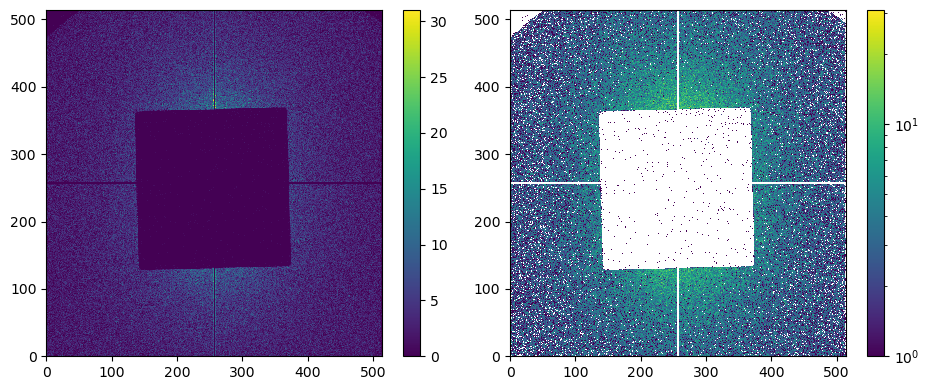

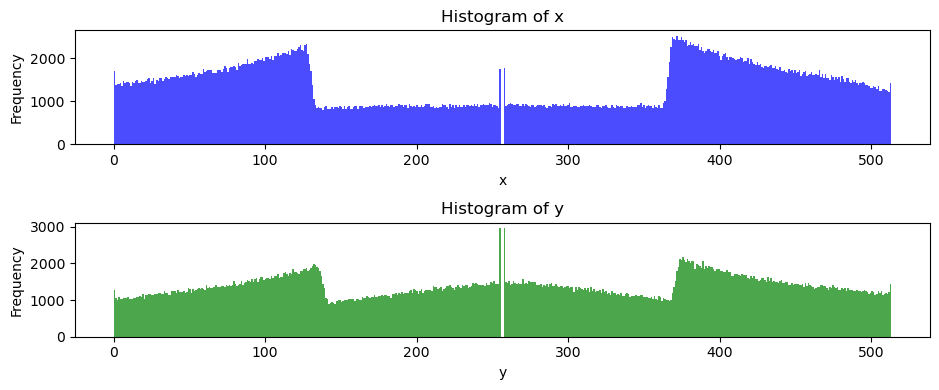

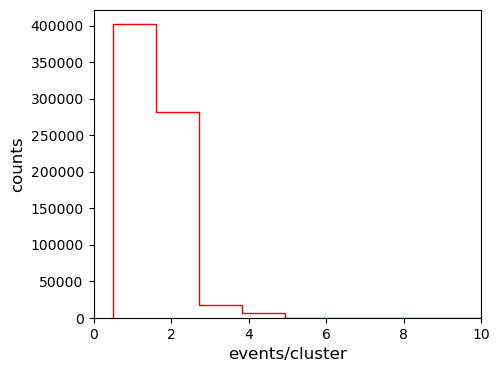

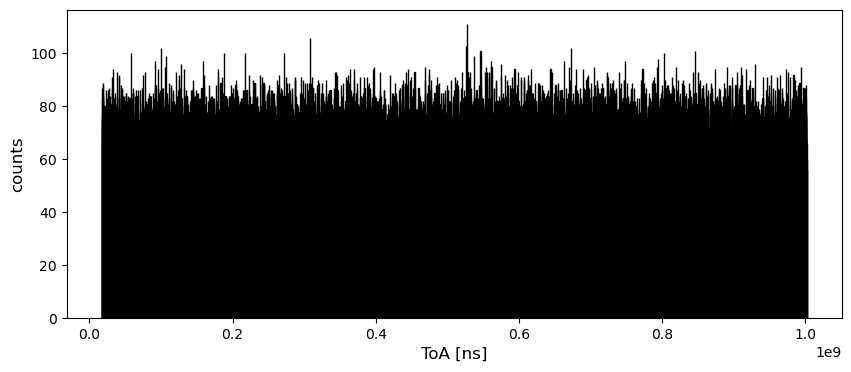

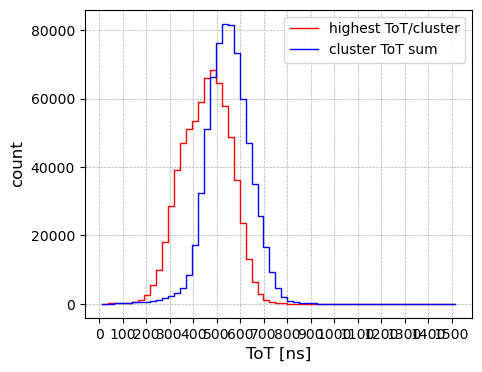

In [10]:
nbins = 514
npixels = 514

hist_data = histogram2d(cdf['xc'], cdf['yc'], range=[[0, 513], [0, 513]], bins=npixels)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))
h = ax0.pcolormesh(hist_data)
fig.colorbar(h, ax = ax0)
h = ax1.pcolormesh(hist_data, norm=mpl.colors.LogNorm())
fig.colorbar(h, ax = ax1)
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(9.5, 4))
axs[0].hist(cdf['xc'], bins=514, color='blue', alpha=0.7)
axs[0].set_title('Histogram of x')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Frequency')
axs[1].hist(cdf['yc'], bins=514, color='green', alpha=0.7)
axs[1].set_title('Histogram of y')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

nbins = 10
dmin = 0
dmax = 10
bins = np.linspace(dmin, dmax, nbins)
bsize = bins[1]-bins[0]
bshift = bsize/2
hist_data = histogram1d(cdf['n'], bins = nbins, range = [dmin, dmax])
bins = np.linspace(dmin, dmax, nbins)
fig, ax0 = plt.subplots(ncols=1, figsize=(5, 4))
plt.step(bins+0.5, hist_data, 'r', linewidth = 1)
plt.ylim([0, np.max(hist_data)*1.05])
plt.xlim([dmin, dmax])
plt.xlabel('events/cluster',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.show()

nbins = 10000
dmin = cdf['t_ns'].min()
dmax = cdf['t_ns'].max()
bins = np.linspace(dmin, dmax, nbins)
bsize = bins[1]-bins[0]
bshift = bsize/2
hist_data = histogram1d(cdf['t_ns'], bins = nbins, range = [dmin, dmax])
bins = np.linspace(dmin, dmax, nbins)
fig, ax0 = plt.subplots(ncols=1, figsize=(10, 4))
plt.bar(bins+bshift,hist_data ,bsize, color = 'r', edgecolor = 'k')
plt.xlabel('ToA [ns]',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.show()

nbins = 60
dmin = 0
dmax = 1500
bins = np.linspace(dmin, dmax, nbins)
bsize = bins[1] - bins[0]
bshift = bsize / 2

hist_data_1 = histogram1d(cdf['ToT_max'], bins=nbins, range=[dmin, dmax])
hist_data_2 = histogram1d(cdf['ToT_sum'], bins=nbins, range=[dmin, dmax])

fig, ax0 = plt.subplots(ncols=1, figsize=(5, 4))
plt.step(bins + bshift, hist_data_1, 'r', linewidth=1, label='highest ToT/cluster')
plt.step(bins + bshift, hist_data_2, 'b', linewidth=1, label='cluster ToT sum')

plt.xlabel('ToT [ns]', fontsize=12)
plt.ylabel('count', fontsize=12)
#plt.yscale('log')
plt.legend()

# Set grid lines every 50 units
ax0.set_xticks(np.arange(dmin, dmax + 1, 100))  # Set x-axis ticks every 50 units
ax0.grid(True, which='both', linestyle='--', linewidth=0.5)  # Enable grid with dashed lines
plt.show()

In [11]:
tpx.convert_tpx3_files(file_list_1[0:10], print_details = True)

Processing files:   0%|          | 0/10 [00:00<?, ?it/s]

-> Processing 2e51a305-9444-4e92-9a66_00000_000000.tpx3, size: 10.6 MB
Loading 2e51a305-9444-4e92-9a66_00000_000000.tpx3 complete. 1040949 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000000.tpx3 complete. 706381 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000000.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000000.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000000_cent.h5...


Processing files:  10%|█         | 1/10 [00:01<00:13,  1.45s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000000_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000000_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000001.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000001.tpx3 complete. 1054356 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000001.tpx3 complete. 715847 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000001.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000001.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000001_cent.h5...


Processing files:  20%|██        | 2/10 [00:02<00:09,  1.20s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000001_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000001_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000002.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000002.tpx3 complete. 1054535 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000002.tpx3 complete. 715934 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000002.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000002.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000002_cent.h5...


Processing files:  30%|███       | 3/10 [00:03<00:07,  1.11s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000002_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000002_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000003.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000003.tpx3 complete. 1056047 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000003.tpx3 complete. 716846 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000003.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000003.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000003_cent.h5...


Processing files:  40%|████      | 4/10 [00:04<00:06,  1.08s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000003_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000003_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000004.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000004.tpx3 complete. 1053861 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000004.tpx3 complete. 715395 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000004.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000004.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000004_cent.h5...


Processing files:  50%|█████     | 5/10 [00:05<00:05,  1.05s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000004_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000004_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000005.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000005.tpx3 complete. 1054597 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000005.tpx3 complete. 716010 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000005.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000005.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000005_cent.h5...


Processing files:  60%|██████    | 6/10 [00:06<00:04,  1.04s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000005_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000005_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000006.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000006.tpx3 complete. 1056611 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000006.tpx3 complete. 716993 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000006.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000006.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000006_cent.h5...


Processing files:  70%|███████   | 7/10 [00:07<00:03,  1.04s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000006_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000006_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000007.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000007.tpx3 complete. 1054351 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000007.tpx3 complete. 715617 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000007.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000007.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000007_cent.h5...


Processing files:  80%|████████  | 8/10 [00:08<00:02,  1.04s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000007_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000007_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000008.tpx3, size: 10.5 MB
Loading 2e51a305-9444-4e92-9a66_00000_000008.tpx3 complete. 1035281 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000008.tpx3 complete. 703006 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000008.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000008.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000008_cent.h5...


Processing files:  90%|█████████ | 9/10 [00:09<00:01,  1.05s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000008_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000008_cent.h5 exists!
Moving onto next file...
-> Processing 2e51a305-9444-4e92-9a66_00000_000009.tpx3, size: 10.7 MB
Loading 2e51a305-9444-4e92-9a66_00000_000009.tpx3 complete. 1054789 events found.
Clustering 2e51a305-9444-4e92-9a66_00000_000009.tpx3 complete. 716212 clusters found. Saving 2e51a305-9444-4e92-9a66_00000_000009.h5...
Saving 2e51a305-9444-4e92-9a66_00000_000009.h5 complete. Centroiding...
Centroiding complete. Saving to 2e51a305-9444-4e92-9a66_00000_000009_cent.h5...


Processing files: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

Saving 2e51a305-9444-4e92-9a66_00000_000009_cent.h5 complete. Checking file existence...
Confirmed 2e51a305-9444-4e92-9a66_00000_000009_cent.h5 exists!
Moving onto next file...


In [12]:
tpx.convert_tpx3_files_parallel(file_list_1, num_workers = 64)

Processing files: 100%|██████████| 1200/1200 [00:36<00:00, 33.16it/s]


Successfully converted 1200 out of 1200!
